<a href="https://colab.research.google.com/github/Raoufmamedov/-GPN_Intelligence-DS_Oil_Retail/blob/main/%D0%A1intra_phoenix_oils.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import string
import re
import time
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download as nltk_download
from nltk.stem import WordNetLemmatizer
!pip install pyaspeller
from pyaspeller import YandexSpeller

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from pyaspeller import YandexSpeller
def spellcheck(text):
    speller = YandexSpeller()
    changes = {change['word']: change['s'][0] for change in speller.spell(text)}
    for word, suggestion in changes.items():
            text = text.replace(word, suggestion)
    return text

In [3]:
# from pyaspeller import YandexSpeller
# import re
# from multiprocessing import Pool

# def spellcheck_word(word):
#     speller = YandexSpeller()
#     changes = speller.spell(word)  # Обратите внимание: speller.spell(word), а не ' '.join(words)
#     if word in changes:
#         return changes[word]['s'][0]
#     return word

# def spellcheck(text):
#     words = re.findall(r'\b\w+\b', text)
#     with Pool() as pool:
#         corrected_words = pool.map(spellcheck_word, words)
#     return ' '.join(corrected_words)



In [4]:
sw=set(stopwords.words("russian"))

In [5]:
# !pip install torch torchvision torchaudio

Загружаем основные необходимые нам библиотеки и убеждаемся в том что мы задействуем графический процессор

In [6]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")

Mounted at /content/drive


In [7]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [8]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 150)

Загружаем и смотрим текст

In [9]:
df=pd.read_json('./cintra_phoenix_oils_hr_mgck_feather.json')

FileNotFoundError: File ./cintra_phoenix_oils_hr_mgck_feather.json does not exist

In [ ]:
df.head(15)

In [ ]:
df=df.set_index('id')

Для тематического моделирования, а именно к нему и относится решаемая задача, наличие знаков препинания в тексте не является критичным. В конце концов даже сложносоставные дефисные слова у нас состоят из слов следующих в определённом порядке, в этом смысле они мало чем отличаются от слов в устойчивых словосочетаниях. Исходя из этого предположения, очистим наш текст от знаков пепинания, которые прилипая к слову, создают его искажённые формы, а заодно приведём весь текст к нижнему регистру

In [ ]:
df.quote=df.quote.apply(lambda x: re.sub(r'[^\w\s]', '', x)).str.lower()
df.quote

In [ ]:
# os.listdir()

In [ ]:
pwd

Мы видим что в начале текста часто идёт приветствие "мурр/муrr". Найдём все формы и добавим их в стоп-лист.


In [ ]:
import re

def myrr_words(text, patterns):
    words = text.split()
    matched_words = [word for word in words if any(re.search(pattern, word, re.IGNORECASE) for pattern in patterns)]
    return matched_words

In [ ]:
patterns = ['мур', 'муrr', 'ммур', 'мyp', 'муrr']
myrr = df.quote.apply(lambda x: myrr_words(x, patterns))
myrr_sw=list(set(pd.Series([word for sublist in myrr for word in sublist]).values))

In [ ]:
myrr_sw=[myrr for myrr in myrr_sw if myrr not in ['мурривеле', 'мурривеле,',
                                         'мурривеле', 'мурривелле', 'мурривель',
                                         'мурривель,', 'мурривеля',
                                         'мурриивеле','муривеле', 'хмуро']]

myrr_sw

In [ ]:
sw.update(myrr_sw)


Также, добавим в стоп-лист стоп-слова из стоплиста ВШЭ.

In [ ]:
!wget https://raw.githubusercontent.com/dhhse/dh2020/master/data/stop_ru.txt

In [ ]:
hsesw=pd.read_csv('stop_ru.txt', header=None)[0].to_list()
sw.update(hsesw)

### Первичная очистка от стоп-слов

Как мы видим, в тексте большое количество грамматических ошибок и опечаток. В таком виде как он есть, его использовать нельзя, необходимо предварительно очистить его и поправить ошибочные написания, а также, при необходимости провести его нормализацию (лемматизацию).


Для начала очистим тексты от стоп-слов, для того чтобы облегчить последующую проверку написания. Для контроля этого процесса, будем фиксировать количество символов и слов до и после очистки, а полученные разницы (относительные), будем визуализировать

In [ ]:
df['wc_0']=df.quote.apply(lambda x: len(x.split(' ')))
df['len_0']=df.quote.str.len()
df.quote=df.quote.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in sw]))
df['wc_1']=df.quote.apply(lambda x: len(x.split(' ')))
df['len_1']=df.quote.str.len()
df['wr']=100*(1-df['wc_1']/df['wc_0']).round(3) # процентное уменьшение количества слов
df['lenr']=100*(1-df['len_1']/df['len_0']).round(3) # процентное уменьшение длины строки
df[['wr', 'lenr']].head().T

In [ ]:
df[['wr', 'lenr']].describe().T.round(1)

In [ ]:
sns.histplot(df[['wr', 'lenr']], kde=True)
plt.title('распределение разниц количества слов и длины строки')
plt.show()

Полученные данные позволяют нам сделать следующие выводы:


1. Значительное сокращение количества слов и длины строки: примерно половина слов в тексте были стоп-словами и после их удаления длина строки уменьшилась более чем на 30 %.
2. Оба распределения нормальны и смещены друг относительно друга. Медианное wr (50.7 %) значительно больше, чем медианное lenr (30,6 %), что говорит о наличии большого количества коротких стоп-слов, таких как предлоги ("в", "на", "из"), союзы ("а", "и") и пр.
3. Довольно высокая вариативность в уменьшении количества слов и длины строки в разных предложениях,  и практически одинаковое стандартное отклонение 9.9 для wr("количество слов") и 10 для lenr ("длина строки").

Посмотрим как выглядит их совместное распределение:

In [ ]:
sns.jointplot(data=df, x='lenr', y='wr')
plt.axvline(x=df.lenr.median(), color='crimson', label='медиана lenr', linestyle='--')
plt.axhline(y=df.wr.median(), color='crimson', label='медиана wr', linestyle='--')
plt.grid()
plt.show()

Ожидаемо, мы имеем линейную зависимость. Из данного графика видно, что у насимеется одна строка, которая изначально не содержала ничего "лишнего". Вот её содержание:

In [ ]:
df[df['lenr']==0].quote

Все ли общераспространённые слова мы удалили, или нам нужно доудалить какие-то слова?  Посмотрим, какими словами изобилует наш текст.

Посмотрим, какими словами изобилует наш текст.

In [ ]:
def word_freq(df):
  plt.figure( figsize=(7,6) )
  wstr=' '.join(df)
  wl=wstr.split(" ")
  wfd=pd.DataFrame(Counter(wl), index=['Qty']).T.sort_values('Qty', ascending=False)
  wordcloud = WordCloud(width=700, height=600, margin=1).generate(wstr)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.margins(x=0, y=0)
  plt.show()
  return wfd

In [ ]:
corpus_wf=word_freq(df.quote)

In [ ]:
corpus_wf.head(20).T

Итак, у нас самым популярным словом является слово дон. Возможно речь идёт о благородных донах, или о региональных офисах на юге Цитрии? Посмотри контексты использования этого слова

In [ ]:
pd.set_option('display.max_colwidth', 130)
display(df.quote[df.quote.str.contains('дон')].head(5))
pd.set_option('display.max_colwidth', 70)

Как мы видим, данное слово почти всегда не несёт в себе никакого смысла, являясь скорее всего паразитом или междометием. И тут мы кое что вспоминаем :)

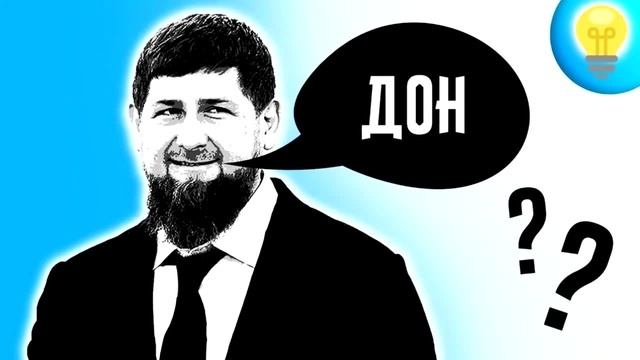



> «Это "дуй хьунан", я для связки слов говорю, как "короче говоря" вот»
>

> Рамзан Кадыров, Глава Чеченской Республики






Как мы видим, эта связка популярна не только в Чечне. Маловероятно, что это слово как-то поможет нам разделить темы, поэтому мы избавляемся от него. Также нам надо разобраться со словами содержащими и не содержащими "змс"/"зсм" и "цмф" (заводы как я понимаю)

Разделим датасет на подгруппы содержащие и не содержащие эти слова, и посмотрим как в них распределены слова

In [ ]:
condition = df['quote'].str.contains('зсм|цмф|змс|дон', case=False)
wo, w=[*df.groupby(condition).quote]

In [ ]:
word_freq(w[1])[:20].T

In [ ]:
word_freq(wo[1])[:20].T

Мы видим что мешки слов с этими словами и без них не сильно отличаются, дач что их удаление. по всей видимости не причинит вреда. Удаляем эти слова и ранее обсуждавшиеся слова, а также слова паразиты и малозначимые слова который нам встречаются в этих мешках.

In [ ]:
abnd_sw=['дон', 'цмф',	'змс', 'зсм',	'понимаешь',	'както', 'вроде', 'например',
         'скать',	'масло',	'масла', 'цк', 'конкретно', 'говорят', 'както',
         'чтото',	'вообще',	'цк',	'работа',	'этo', 'знаю',	'равно', 'походу', 'ктото']

In [ ]:
sw.update(abnd_sw)

In [ ]:
df.quote=df.quote.apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in sw]))

Посмотрим на очищенный текст

In [ ]:
df.quote.head()

Текст содержит большое количество опечаток и задвоений. Попробуем его очистить.

Были предприняты попытки исправить ошибки с помощью DeepPavlov, но при попытке осуществить это на компьютере, возникли сложности с совместимостью пакетов. На колабе был опробован спеллчеккер на модели 'UrukHan/t5-russian-spell' (https://huggingface.co/UrukHan/t5-russian-spell), но модель работала очень долго (15 минут) и требовала использования GPU.

Поиск альтернативного решения привёл к спел-чеккеру Yandex, который и был использован. При меньших временных затратах (около 9 минут), программа обошлась использованием CPU.

In [ ]:
s_t=time.time()
df_quote_schke=df.quote.apply(spellcheck)
e_t=time.time()
delta=e_t-s_t

In [ ]:

print(delta/60)

In [ ]:
pd.DataFrame([df_quote_schke, df.quote]).T

Спел-чеккер отрабатывает достаточно качественно и быстра, затруднения у него возникают при обработке слов с пропусками либо слов имеющих более двух дублирующихся букв. В будущем, желательно провести доочисту корпуса, но сейчас мы ограничимся текущим уронем предобработки. Для контроля, сохраняем корпус в файл формата json

In [ ]:
df_quote_schke.to_json('cintra_phoenix_oils_spellchecked.json')

Сохранив файл двигаемся дальше и подвергаем наш корпус лемматизации

# Лемматизация

Проведём токенизацию с помощью токенайзера NLTK и лемматизацию c помощью пакета pymorhy2

In [ ]:
from nltk.tokenize import word_tokenize


In [ ]:
import nltk
nltk.download('punkt_tab')

In [ ]:
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer

parser = MorphAnalyzer()

def toklem_preproc(series):
    tokenized = word_tokenize(series)
    clean_text = [word for word in tokenized if word not in sw]
    lemmatized = [parser.parse(word)[0].normal_form for word in clean_text]

    return lemmatized

In [ ]:
tlp=df_quote_schke.apply(toklem_preproc)

In [ ]:
tlp

In [ ]:
a=" ".join(df.quote).split()
print(a)

Для тематического моделирования, мы будем использовать пакет Gensim. Создадим в нём словарь, отфильтровав из него слова с долей встречаемости в текстах более 0.1 и количеством документов в которых они встречаются, не менее 3. После этого создаём корпус и передаём его для в функцию сознания модели латентного размещения Дирихле

In [ ]:
import gensim

gensim_dictionary = gensim.corpora.Dictionary(tlp)
gensim_dictionary.filter_extremes(no_above=0.1, no_below=3)
gensim_dictionary.compactify()
corpus = [gensim_dictionary.doc2bow(txt) for txt in tlp]
lda_10 = gensim.models.LdaMulticore(corpus,
                                 num_topics=10,
                                 id2word=gensim_dictionary,
                                 passes=50, random_state=42)

In [ ]:
lda_10.print_topics()

Мы видим, что тематическое моделирование позволяет нам выделить следующие темы:

0) Ивент-менеджмент

1) Оборудование

2) Сбытовые операции

3) Сравнение условий оплаты труда в компаниях-конкурентах

4) Схема оплаты труда

5) Производственный процесс

6) Маркетинг

7) Возможно круглосуточная торговля

8) Система квартального и годового премирования

9) Отношения в коллективе





In [ ]:
gensim_dictionary = gensim.corpora.Dictionary(tlp)
gensim_dictionary.filter_extremes(no_above=0.1, no_below=3)
gensim_dictionary.compactify()
corpus = [gensim_dictionary.doc2bow(txt) for txt in tlp]
lda_10 = gensim.models.LdaMulticore(corpus,
                                 num_topics=10,
                                 id2word=gensim_dictionary,
                                 passes=100, random_state=42)

text_to_classify_1='Когда новый палантир будет'
new_text_corpus_1 =  id2word.doc2bow(text_to_classify_1.split())
lda_10[new_text_corpus_1]

In [ ]:
lda_10.show_topics(num_topics=10, num_words=10, formatted=True)

# Обсуждение результатов



1.   Нам удалось выделить 10 тем к которым предположительно относятся документы созданные самопишущим цидарийским пером.
2.  LDA позволяет обновлять корус (update), а также предсказывать класс текста.

